# Project description
Type 1 diabetes is a disease which results from loss of the beta cells within the pancreas.  Such cells produce insulin, which controls the glucose level in your blood.  When glocuse is too high one feels sick, and verve damage is possible.  When glucose is too low I can go unconciouss, and there is a risk of falling into a coma.

## Analysis and Data exploration
In this section we look at the raw data. We propose the $\Gamma$-hypothesis based on visuals and physical grounds.

### Description of the data
 *Dexcom Share* exports the data from the Dexcom G5 CGM to the *iphone* Health application.  The health applicaiton then exports the raw blood glucose readings as a csv file with the help of *QS access*.  Similarly, *Mu Glucose Buddy* allows me to log all of my meals and insuling dosages on my *iphone* and export the data as a csv file.

In [11]:
import pandas as pd
start_date = '2016-05-06' #I only started collecting seriously around May 6th
bg_data = pd.read_csv("Blood Glucose.csv",usecols=[0,2], parse_dates=True,index_col=0,
                      squeeze=True)
bg_data = bg_data[start_date:]
dose_data = pd.read_csv("MyExportedGlucoseBuddyLogs.csv",header=0,index_col='Date Time',
                        parse_dates=True,infer_datetime_format=True)
dose_data = dose_data[start_date:]

Below I plot a typical day of blood sugars along with insulin dosages and meals.  The red line denotes the blood sugar.  A green dot indicates that insuling was dosed at that time, and a blue dot indicates that food was consumed.

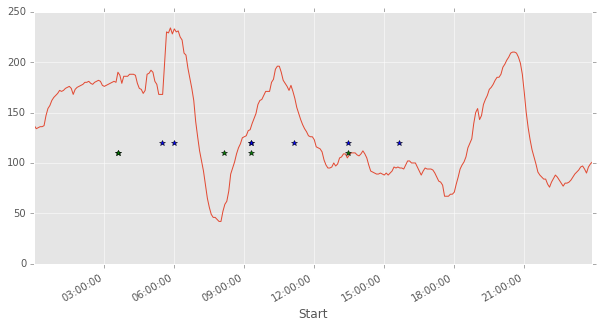

In [12]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import numpy as np

date = '2016-05-21'
fig = plt.figure( figsize = (10,5))
bg_data[date].plot()
food = dose_data[dose_data['Type']=='F'][date]
meds = dose_data[dose_data['Type']=='M'][date]
plt.plot( food.index , 120*np.ones(food.index.size),'b*')
plt.plot( meds.index , 110*np.ones(meds.index.size),'g*')

The blood glucose data is *not* normally distributed.  We observe a smooth distribution that vaguely represents a $\Gamma$-distribution with an average aroung $\bar{g} \approx 140$ and a shape parameter of $k \approx 1.5$.

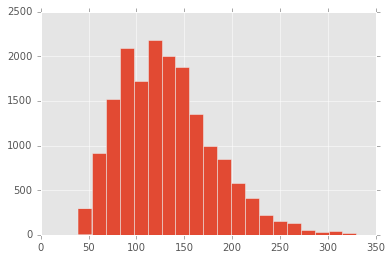

In [13]:
bg_data.hist(bins=20)

  On theoretical grounds, we'd like to deal with data that is described well by Normal distributions.
  However, blood glucose readings are positive, in fact they must be somewhere above 20 mg/dL in order for the person to be alive.  On the other end of readings, my blood will eventualy saturate with glucose and never rise beyond 600 mg/dL. We can transform the the interval $[20,600]$ so that $20$ maps to $-\infty$ and $600$ maps to $+\infty$ using the transformation
$$
    T(g) = {\rm arctanh} \left( \frac{2 (g - g_{min} )}{g_{max}} - 2 \right).
$$
Upon transforming the blood glucose readings, $g(t)$, we find that $x(t) = T(g(t))$ is well approximated by a normal distribution.

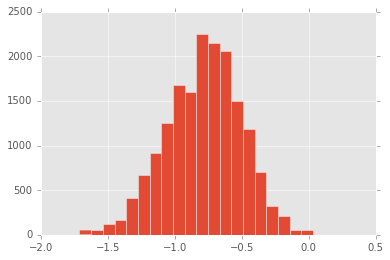

In [14]:
max_BG = 600
min_BG = 20
transform = lambda x : np.arctanh( 2.0*(x-min_BG)/max_BG - 1 )
transformed_data = bg_data.apply( transform )
transformed_data.hist(bins=20)

##Isolating the affect of insulin on BG
In theory, dosing insulin will reduce blood glucose levels over time.  Unfortunately, it is difficult to glean this theoretical prediction from the data because insulin only partially explains one's blood glucose.  Blood glucose varies according to diet, sleep, exercise, stress, and numerous other factors.  However, we can attempt to isolate the affect of insulin on the CGM readings by looking for incidents where insulin was dosed in the absence of food (within a 4 hour window before and after).

Below we plot the (transformed) output of the CGM up to 5 hours after an isolated insulin dose.  We see towards the tail end of many of these events, that the BG will drop.  Typically these isolated dosages are administered to prevent an already high and rising BG from rising further.  Thus, many of the curves have a peak around 3 hours before BG begins to fall.  In anycase, this lends credence to the hypothesis that dosing insulin decreases blood sugar levels.  However, we can see it's pretty noisy, and there is a very long lag time.

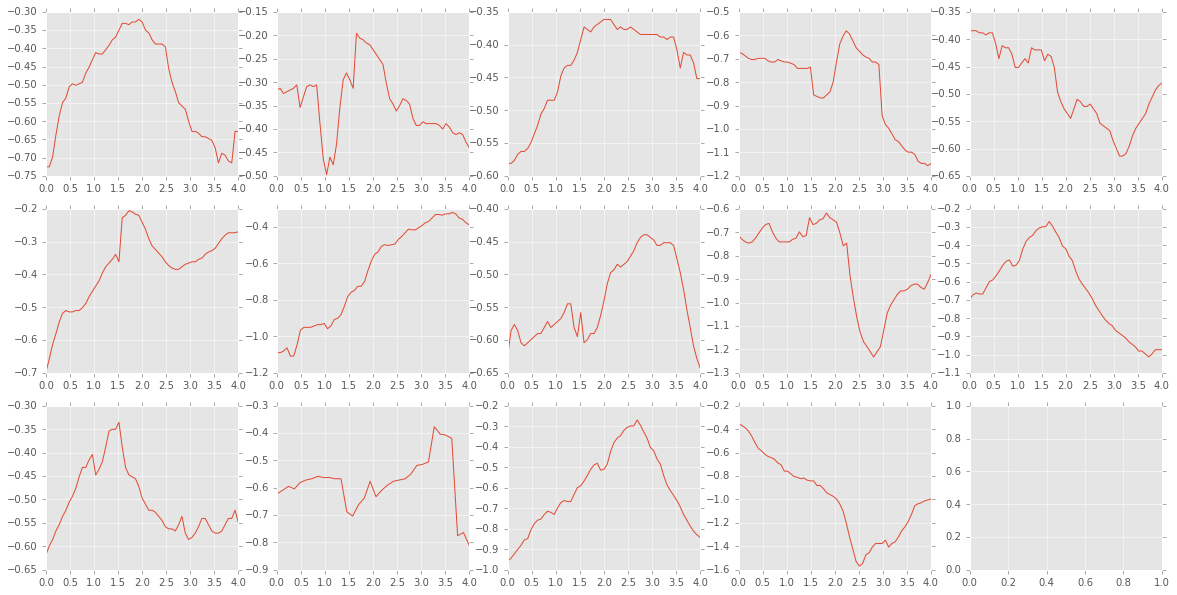

In [16]:
#First we detect incidents of isolated insuling dosages
insulin_times = dose_data[dose_data['Type']=='M'].index
from pandas.tseries.offsets import DateOffset
isolated_insulin_times = []
offset = DateOffset(hours=4)
for time in insulin_times:
    if dose_data[dose_data['Type']=='F'][time-offset:time+offset].empty:
        isolated_insulin_times.append(time)
isolated_insulin_times = set(isolated_insulin_times)

#Now we plot
offset = DateOffset(hours=5)
fig,ax_arr = plt.subplots( 3,5 , figsize=(20,10) )
ax_arr = ax_arr.flatten()
for k,time in enumerate(isolated_insulin_times):
    if k==len(isolated_insulin_times) or k==15:
        break
    y = transformed_data[time:time+offset].values
    x = np.linspace( 0,4,len(y) )
    ax_arr[k].plot(x,y)

##Isolating the effects of food on BG
We can do the same excercise with food.  Again, we search for incidents of food consumption in the absence of insulin (within a 3 hour window this time).  The incidents here mirror those of the previous section.  I typically only consume food in the absence of insulin when my BG is low and falling.  When we plot the results we find many curves dip at aroung 2 hours before the BG rises.

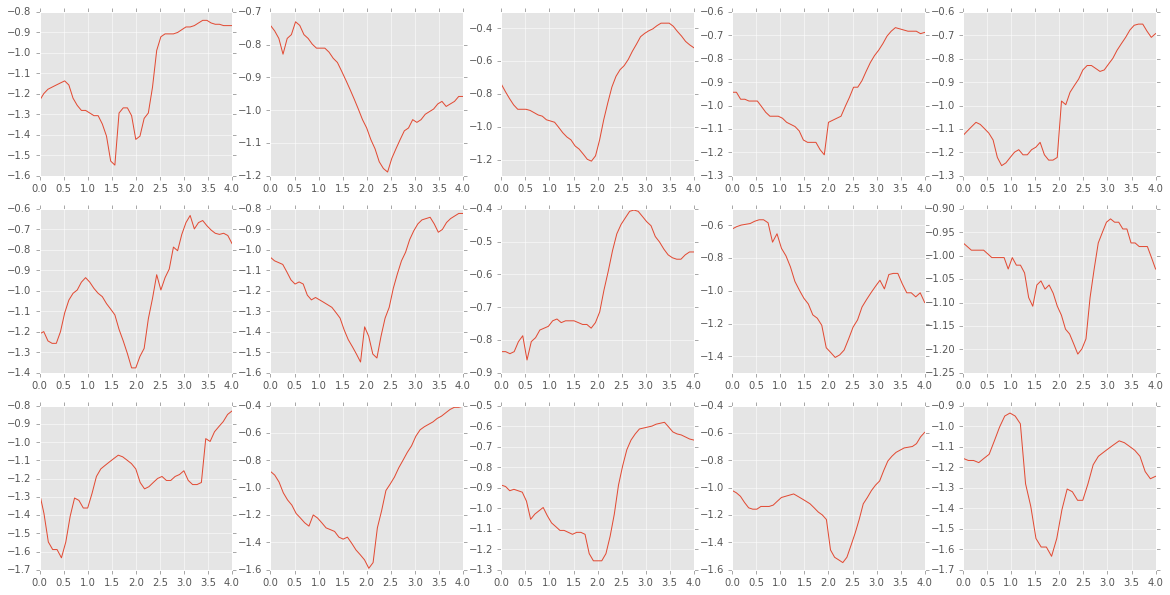

In [21]:
food_times = dose_data[dose_data['Type']=='F'].index
isolated_food_times = []
offset = DateOffset(hours=4)
for time in food_times:
    if dose_data[dose_data['Type']=='M'][time-offset:time+offset].empty:
        isolated_food_times.append(time)

isolated_food_times = set( isolated_food_times)

offset = DateOffset(hours=4)
fig,ax_arr = plt.subplots( 3,5 , figsize=(20,10) )
ax_arr = ax_arr.flatten()
for k,time in enumerate(isolated_food_times):
    if k==15:
        break
    y = transformed_data[time:time+offset].values
    x = np.linspace( 0,4,len(y) )
    ax_arr[k].plot(x,y)

## Models
In this section we introduce a few models which we will try to fit.

### Model 1:
Let $g(t)$ denote the blood glucose level at time $t$.  Assume insulin is administered at times $\{ t_{i,k} \}_{k=1}^{N_i}$ and food intake at times $\{ t_{f,k} \}_{k=1}^{N_f}$
the most simple model which adpots the $\Gamma$-hypothesis would be

$$
    g(t) = g(0) + c_i \left( \sum_{t_{i,k} < t } \int_{t_{i,k}}^t \frac{\tau}{\lambda_i} e^{-\tau / \lambda_i} d\tau \right)
        + c_f \left( \sum_{t_{f,j} < t } \int_{t_{f,j} }^t \frac{\tau}{\lambda_f} e^{-\tau / \lambda_f } d\tau \right) + Noise.
$$
This might be a good model to try first.  One critique is that it allows for the implausible cases where $g(t) < 0$.

### Model 2:
To prohibit negative glucose predictions we could introduce the auxiliary variable $x(t) = \log(g(t))$ and consider the model:
$$
    x(t) = x(0) + c_i \left( \sum_{t_{i,k} < t } \int_{t_{i,k}}^t \frac{\tau}{\lambda_i} e^{-\tau / \lambda_i} d\tau \right)
        + c_f \left( \sum_{t_{f,j} < t } \int_{t_{f,j} }^t \frac{\tau}{\lambda_f} e^{-\tau / \lambda_f } d\tau \right) + Noise.
$$
One could still make a similar critique.  Glocuse reading can only be so high: eventually physical process, such as the blood's chemical saturation level prevent higher glucose levels.

### Model 3:
To prohibit unusually high glucose readings we consider a function which diverges to infinity at $600$ mg/dL and diverges to negative infinity at zero.  For example, we could consider a rescaled and offset `arctanh` function.
We will consider the auxiliary variable
$$
    x(t) = {\rm arctanh}\left( \frac{2 g(t)}{g_{\rm max} } -1 \right)
$$
and again consider the model:
$$
    x(t) = x(0) + c_i \left( \sum_{t_{i,k} < t } \int_{t_{i,k}}^t \frac{\tau}{\lambda_i} e^{-\tau / \lambda_i} d\tau \right)
        + c_f \left( \sum_{t_{f,j} < t } \int_{t_{f,j} }^t \frac{\tau}{\lambda_f} e^{-\tau / \lambda_f } d\tau \right) + Noise.
$$

### Models 4,5,6:
I notice that my insuling sensitivity at Lunch is typically lower than my insulin sensitivity at breakfast.  Perhaps I should break the day into three parts, and consider difference coefficients for each time of day.


## Implementation
We desire to fit the parameter tuple $\theta = (\lambda_i,\lambda_f,c_i,c_f)$ to our data.
Our data is given by trajectories $x_\alpha(t)$ for $\alpha = 1,\dots,N$.
For each model we consider the cost function
$$
    C(\theta) = \sum_{\alpha=1}^N \| x_\alpha - x_{pred,\alpha}( \theta ) \|_{L_1}
$$
where the predicted trajectory is given by
$$
    x_{pred,\alpha}(\theta)(t) = x_\alpha(0) + c_i \left( \sum_{t_{i,k}<t} G(t,\lambda_i) \right) +  c_f \left( \sum_{t_{i,k}<t} G(t,\lambda_f) \right)
$$
We preform minimization using scipy's optimization module.

## Results
We did okay. Need more data probably

## Conclusion
Customized medicine